# 인물 사진 만들어보기 프로젝트

### 사용할 모듈 불러오기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### PixelLib 모델 받아오기 

In [2]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe9104fb490>)

In [3]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

## (1) 내 사진!

### 이미지 불러오기

(714, 941, 3)


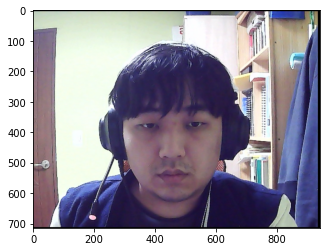

In [4]:
me_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img123.png'  
me_orig = cv2.imread(me_path) 

print(me_orig.shape)
plt.imshow(cv2.cvtColor(me_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 모델에 이미지 입력

In [5]:
segvalues, output = model.segmentAsPascalvoc(me_path)

##### PASCAL VOC 데이터 라벨 종류

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

데이터 라벨 종류에는 백그라운드를 제외하고 총 20가지가 있다.   
진행하고 있는 내용에서 우리가 필요한 것은 사람 라벨, person 을 필요로 하니까 15.

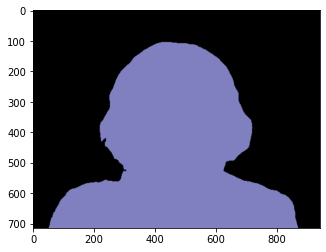

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]

array([192, 128, 128])

In [12]:
seg_color = (128,128,192)

(714, 941)


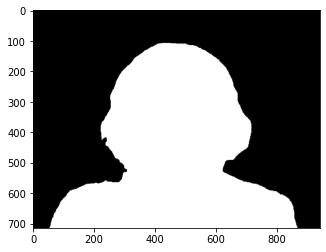

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

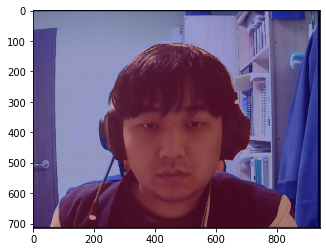

In [14]:
me_show = me_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
me_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(me_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
me_show = cv2.addWeighted(me_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(me_show, cv2.COLOR_BGR2RGB))
plt.show()

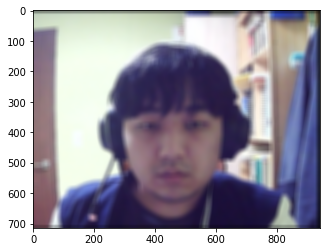

In [15]:
me_orig_blur = cv2.blur(me_orig, (20,20))  
plt.imshow(cv2.cvtColor(me_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

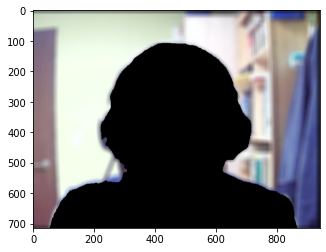

In [16]:
me_mask_color = cv2.cvtColor(me_mask, cv2.COLOR_GRAY2BGR)
me_bg_mask = cv2.bitwise_not(me_mask_color)
me_bg_blur = cv2.bitwise_and(me_orig_blur, me_bg_mask)
plt.imshow(cv2.cvtColor(me_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

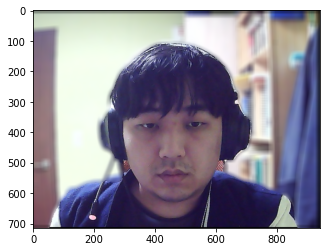

In [17]:
me_concat = np.where(me_mask_color==255, me_orig, me_bg_blur)
plt.imshow(cv2.cvtColor(me_concat, cv2.COLOR_BGR2RGB))
plt.show()

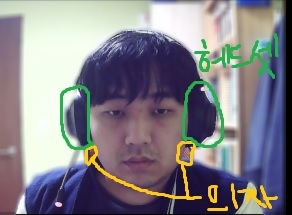

###### 문제점
1. 머리 뒤쪽의 의자부분이 포함되었음.   
2. 헤드셋이 한쪽은 포함되고 한쪽은 포함되지않음.   
   포함된 한쪽은 음영이 없이 검은색만 있어서 머리카락으로 인식된게 아닐까?

---

## (2) 고양이 사진

### 이미지 불러오기

(449, 800, 3)


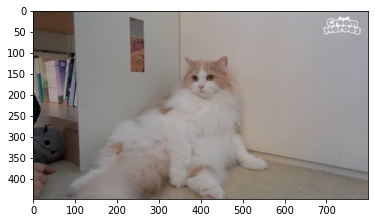

In [18]:
dd_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/catdd.jpg'  
dd_orig = cv2.imread(dd_path) 

print(dd_orig.shape)
plt.imshow(cv2.cvtColor(dd_orig, cv2.COLOR_BGR2RGB))
plt.show()

유튜브 크림히어로즈의 디디를 데리고 왔다.

### 모델에 이미지 입력

In [19]:
segvalues, output = model.segmentAsPascalvoc(dd_path)

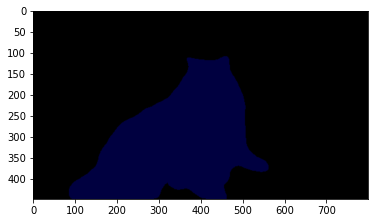

In [20]:
plt.imshow(output)
plt.show()

In [21]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [22]:
colormap[8]

array([64,  0,  0])

In [23]:
seg_color = (0,0,64)

(449, 800)


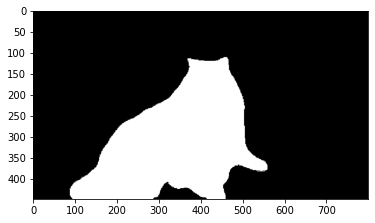

In [24]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

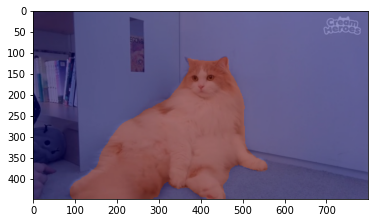

In [25]:
dd_show = dd_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
dd_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(dd_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
dd_show = cv2.addWeighted(dd_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dd_show, cv2.COLOR_BGR2RGB))
plt.show()

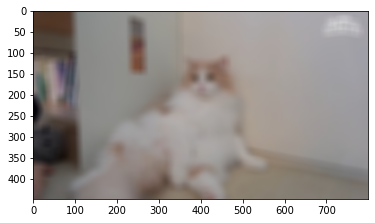

In [26]:
dd_orig_blur = cv2.blur(dd_orig, (20,20))  
plt.imshow(cv2.cvtColor(dd_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

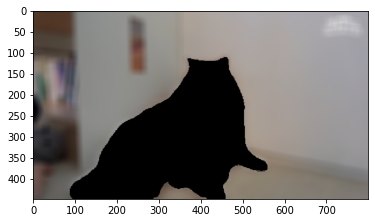

In [27]:
dd_mask_color = cv2.cvtColor(dd_mask, cv2.COLOR_GRAY2BGR)
dd_bg_mask = cv2.bitwise_not(dd_mask_color)
dd_bg_blur = cv2.bitwise_and(dd_orig_blur, dd_bg_mask)
plt.imshow(cv2.cvtColor(dd_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

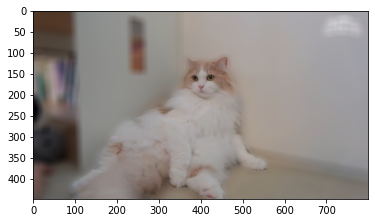

In [28]:
dd_concat = np.where(dd_mask_color==255, dd_orig, dd_bg_blur)
plt.imshow(cv2.cvtColor(dd_concat, cv2.COLOR_BGR2RGB))
plt.show()

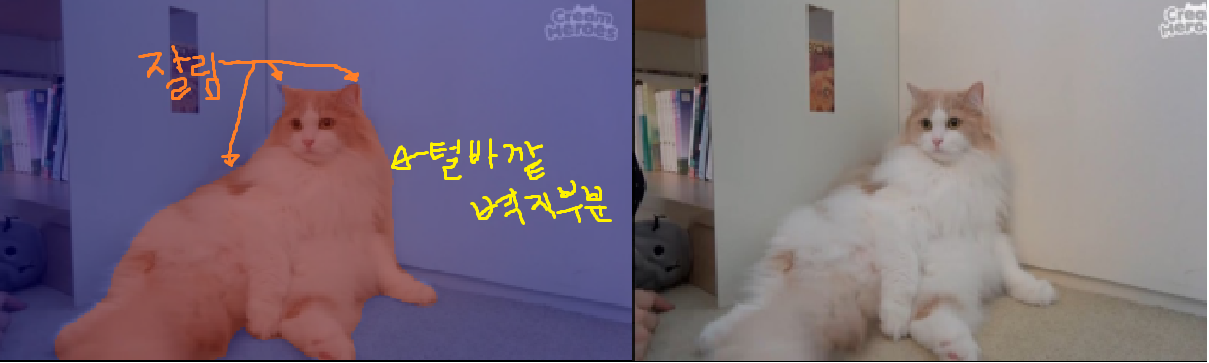

###### 문제점   

1. 오른쪽, 털 바깥의 벽지부분 음영도 고양이 범위에 포함됐다.
2. 귀 끝과 약간의 바깥 털들이 경계에 잘려 포함되지 못했다.

털 색이 벽지 색과 비슷해서 그런걸까? 싶어서 다른 고양이 사진도 들고와봐야겠다.

## (3) 배경 전환 크로마키 사진

(3456, 5184, 3)


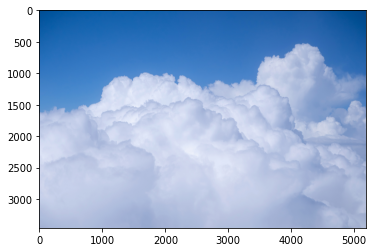

In [29]:
back_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cloud.jpg'  
back_orig = cv2.imread(back_path) 

print(back_orig.shape)
plt.imshow(cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [30]:
back_resized = cv2.resize(back_orig, (dd_orig.shape[1], dd_orig.shape[0]))

구름 사진 사이즈를 디디 사진 사이즈에 맞춰주었다.

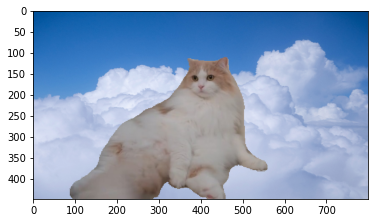

In [31]:
dd_back_concat = np.where(dd_mask_color == 255, dd_orig, back_resized)
plt.imshow(cv2.cvtColor(dd_back_concat, cv2.COLOR_BGR2RGB))
plt.show()

구름에 기대 누워있는 디디 사진이 완성되었다!

## (4) 또 다른 고양이..

(720, 1280, 3)


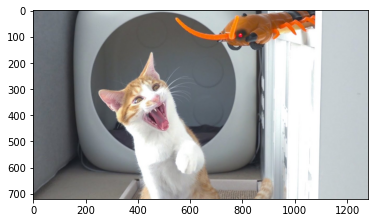

In [32]:
toto_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cattoto.jpg'  
toto_orig = cv2.imread(toto_path) 

print(toto_orig.shape)
plt.imshow(cv2.cvtColor(toto_orig, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 크림히어로즈의 또 다른 고양이, 토토를 데리고 왔다.   
디디 사진과는 달리 배경색과 털색이 확실히 구분이 되는 사진으로 들고왔다.

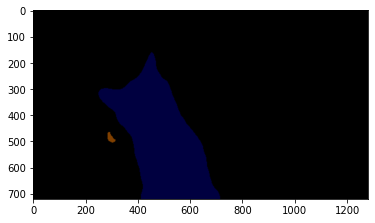

In [33]:
segvalues, output = model.segmentAsPascalvoc(toto_path)
plt.imshow(output)
plt.show()

In [34]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
tv


갑자기 왠 tv...?   
위에 조그만 갈색? 부분을 뭔가 이상하게 인식한것같다.   
어차피 고양이 부분만 생각할거니까 신경쓰지 않겠다.

In [35]:
colormap[8]

array([64,  0,  0])

In [36]:
seg_color = (0,0,64)

(720, 1280)


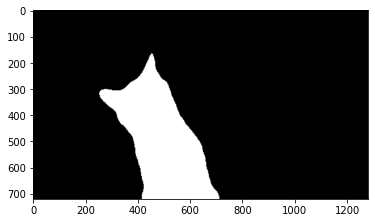

In [37]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

tv로 인식됐던 부분이 사라졌다~

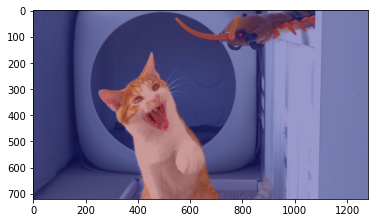

In [38]:
toto_show = toto_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
toto_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(toto_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
toto_show = cv2.addWeighted(toto_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(toto_show, cv2.COLOR_BGR2RGB))
plt.show()

이번엔 blur를 조금 강하게 줘봤다.

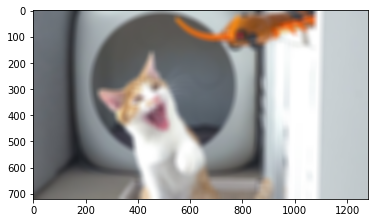

In [39]:
toto_orig_blur = cv2.blur(toto_orig, (25,25))  
plt.imshow(cv2.cvtColor(toto_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

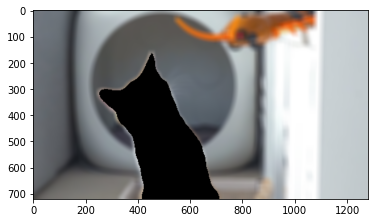

In [40]:
toto_mask_color = cv2.cvtColor(toto_mask, cv2.COLOR_GRAY2BGR)
toto_bg_mask = cv2.bitwise_not(toto_mask_color)
toto_bg_blur = cv2.bitwise_and(toto_orig_blur, toto_bg_mask)
plt.imshow(cv2.cvtColor(toto_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

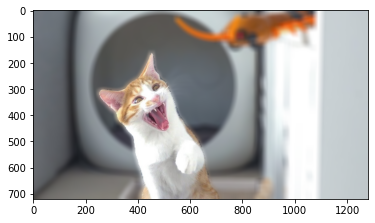

In [41]:
toto_concat = np.where(toto_mask_color==255, toto_orig, toto_bg_blur)
plt.imshow(cv2.cvtColor(toto_concat, cv2.COLOR_BGR2RGB))
plt.show()

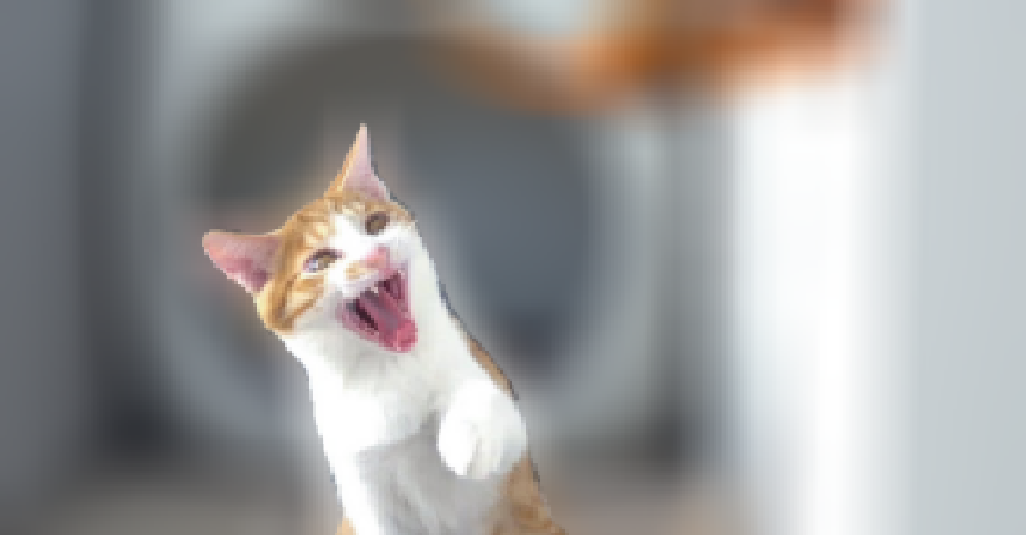
blur를 (100,100) 으로 줬을 때

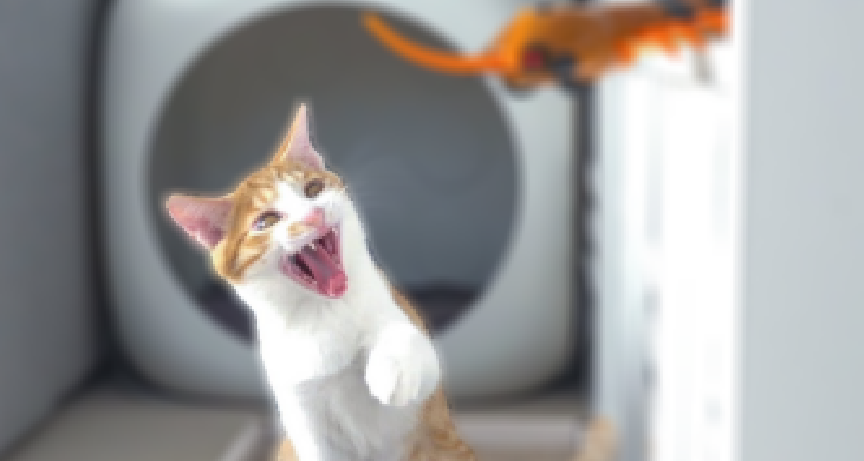
blur를 (25,25) 으로 줬을 때

###### 문제점

디디 사진과는 달리 구분이 잘된 모습이다.   
하지만 blur를 강하게 해보니 확 보이는 경계선이 부자연스러워보인다..

---

## (5) 해결방안 제시

### 가우시안 블러

위에서 사용한 방식에는 블러처리된 배경과 경계선이 나뉘어 부자연스럽다는 문제점이 있다.   
이런 문제점을 해결해보려고 검색해본 결과 가우시안 블러라는 방법을 찾았다.   

In [42]:
# 해당 이미지의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
toto_mask_3C = np.repeat(np.expand_dims(toto_mask, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
toto_orig_Gblur = cv2.GaussianBlur(toto_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
toto_Gmask = (cv2.GaussianBlur(toto_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
toto_blur = toto_Gmask*toto_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
toto_bg_mask = (1-toto_Gmask)*toto_orig_Gblur.astype(np.float32)
toto_output = (toto_blur+toto_bg_mask).astype(np.uint8)

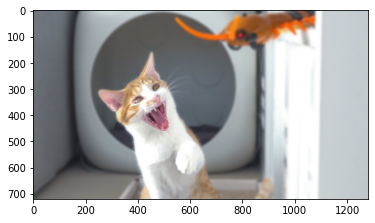

In [43]:
plt.imshow(cv2.cvtColor(toto_output,cv2.COLOR_BGR2RGB))
plt.show()

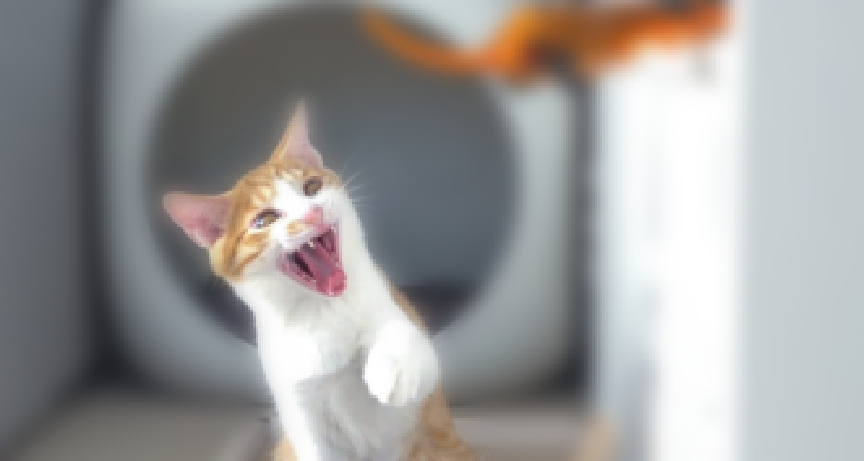

경계선이 없어지고 훨씬 자연스러워 보인다!

디디 사진과 내 사진도 가우시안 블러를 적용시켜보자

In [44]:
# 해당 이미지의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
me_mask_3C = np.repeat(np.expand_dims(me_mask, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
me_orig_Gblur = cv2.GaussianBlur(me_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
me_Gmask = (cv2.GaussianBlur(me_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
me_blur = me_Gmask*me_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
me_bg_mask = (1-me_Gmask)*me_orig_Gblur.astype(np.float32)
me_output = (me_blur+me_bg_mask).astype(np.uint8)

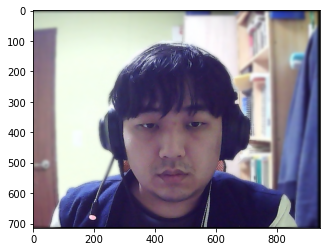

In [45]:
plt.imshow(cv2.cvtColor(me_output,cv2.COLOR_BGR2RGB))
plt.show()

In [46]:
# 해당 이미지의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
dd_mask_3C = np.repeat(np.expand_dims(dd_mask, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
dd_orig_Gblur = cv2.GaussianBlur(dd_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
dd_Gmask = (cv2.GaussianBlur(dd_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
dd_blur = dd_Gmask*dd_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
dd_bg_mask = (1-dd_Gmask)*dd_orig_Gblur.astype(np.float32)
dd_output = (dd_blur+dd_bg_mask).astype(np.uint8)

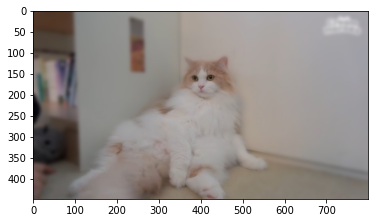

In [47]:
plt.imshow(cv2.cvtColor(dd_output,cv2.COLOR_BGR2RGB))
plt.show()

문제점으로 보였던 부분들이 어느정도 보완이 된 것같다!

---

### semantic segmentation mask의 오류

디디 사진이나 내 사진으로 진행해보면서 본 것만으로도, 배경과 대상을 구분하는게 정확하지 않다는 걸 알 수 있다.   

1. 내가 쓰고있는 헤드셋 같은 경우도, 사람이 착용하고 있는 거니까 사람으로 같이 분류가 되는게 좋지 않을까 생각하지만,   
   실제로 분류가 된건 한쪽은 머리카락으로 인식한 것 같고, 한쪽은 배경으로 인식해서 분류가 되었다.   
2. 그리고 사람 가까이에 있다는 이유로 내 머리 뒤의 의자 머리 받침 쪽이 사람으로 분류가 됐다.   
3. 디디 사진 같은 경우에도, 털 색이 배경 색과 비슷해서 분류가 조금 잘못된 부분이 있는 것 같았다.   


### 오류 개선 방안 제안..
1. 3D 카메라 센서를 통해서 촬영
2. 카메라와, 촬영된 물체, 배경 사이의 거리 depth를 얻는다.
3. 얻은 값을 활용해서 어느정도 depth의 차이가 있는 물체는 따로 분류하도록 한다.

내 사진으로 예를 들자면,
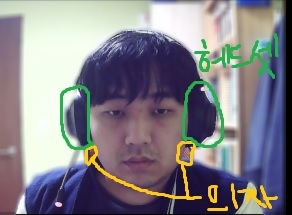
머리 뒷쪽의 의자 부분을 구분해주기 위함으로, 머리 부분과 의자 부분의 depth 차이를 활용해서 의자를 따로 구분시키는 것.

---

## 회고

##### 루브릭 관련 고려한 점
1. 인물모드 사진을 성공적으로 제작하였다.   
   - 인물모드로 진행한 내 사진과, 고양이 사진, 그리고 구름 배경 사진에 고양이 사진을 사용한 배경전환 크로마키 사진을 제작했다.   
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.   
   - 제작한 사진들에서 보이는 여러 문제점들을 표시하고, 어떤 원인으로 문제가 발생했는지 생각해보았다.   
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.   
   - 경계 부분 개선을 위해 가우시안 블러를 사용하여 자연스럽게 표현할 수 있었다.   
   - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 솔루션을 작성하였다.   
   
처음에는 문제가 없었지만 코드를 조금씩 수정해가면서 다시 실행해보다 보면, 결과가 조금 이상하게 나오는 경우가 있어서,   
새로운 시도를 할때마다 그에 맞는 새로운 변수명을 사용해봤다.   
내 사진을 사용할 땐 me를 붙이고 디디 사진은 dd, 토토 사진은 toto를 변수명 앞에 붙여줬다.   
그랬더니 괜찮아진듯한 느낌..   
앞으로도 이런 식으로 여러 시도를 해볼때마다 새로운 변수명으로 바꿔주는게 좋을거같다.

### 참고자료
- 가우시안 블러 코드
https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E14.%20Image%20segmentation%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20Portrait%20mode%20%EB%A7%8C%EB%93%A4%EA%B8%B0..ipynb
- 가우시안 블러에 관한 내용   
https://bkshin.tistory.com/entry/OpenCV-17-%ED%95%84%ED%84%B0Filter%EC%99%80-%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98Convolution-%EC%97%B0%EC%82%B0-%ED%8F%89%EA%B7%A0-%EB%B8%94%EB%9F%AC%EB%A7%81-%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%AF%B8%EB%94%94%EC%96%B8-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%B0%94%EC%9D%B4%EB%A0%88%ED%84%B0%EB%9F%B4-%ED%95%84%ED%84%B0